# Programming assignment 5: spotting cars using convolutional neural networks


### Importing required libraries

Importing required libraries

In [1]:
# required libs
import numpy as np
np.random.seed(0)
# plotting
from matplotlib import pyplot as plt
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
# tensorflow/keras
import tensorflow.keras as keras
from keras import callbacks
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input
# To set the color used to display monochrome images.
plt.rcParams['image.cmap'] = 'Blues'

## Introduction: Loading images from a directory

Some initial setting to be used in notebook

In [2]:
imgdir = 'a5_images'
img_size = 64
channel_rgb = 3 # for the colors red, green and blue
epo = 100 # epoch to iterate through training data n times

Initiate ImageDataGenerator to convert images into NumPy format and rescale it to 0-1 instead of 0-255. 

Function used with generator to fetch images, sets directory, and batch size to be used when importing.

In [3]:
data_gen = ImageDataGenerator(rescale=1.0/255)

Read images in training and validation set

In [5]:
def image_generator(generator, directory, batch_s, boolean):

    img_generator = generator.flow_from_directory(
        imgdir + directory, # location of images
        target_size=(img_size, img_size), # size of image
        batch_size=batch_s, # batch size for training
        class_mode='binary', # binary classification task
        classes=['other', 'car'], # other=0, car=1
        seed=12345, # reproducability
        shuffle=boolean) # random order
        
    return img_generator

Return images from generator for both training and validation

In [6]:
train_directory = '/train'
X_train, Y_train = image_generator(data_gen, train_directory, 1600, True).next()

Found 1600 images belonging to 2 classes.


In [7]:
val_directory = '/validation'
X_val, Y_val = image_generator(data_gen, val_directory, 576, True).next()

Found 576 images belonging to 2 classes.


- Check dimensions (number of images, height of image, width of image, RGB (3) values between 0-1)

In [8]:
print("Shape Train: ", X_train.shape)
print("Shape Val: ", X_val.shape)

Shape Train:  (1600, 64, 64, 3)
Shape Val:  (576, 64, 64, 3)


- Check label of some random image
- Confirm the actual image of the same item by plotting it 

Label:  0.0 
Corresponding image: 


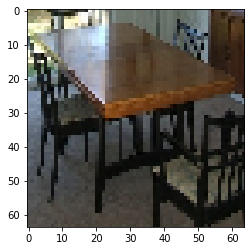

In [9]:
print("Label: ", Y_train[6], "\nCorresponding image: ")
plt.imshow(X_train[6])
plt.show()

## Part 1: Training a convolutional neural network

Settings for early stopping

In [33]:
# early stopping
early_stopping = callbacks.EarlyStopping(
                                        monitor='val_loss', 
                                        mode='min',
                                        patience=10,
                                        restore_best_weights=True, 
                                        verbose=1)

Functions for model, train and summary

In [11]:
def make_convnet(img_size, channel):

    # Initallize network
    model = Sequential() # sequential model

    #add model layers
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(img_size,img_size,channel))) # layer 1
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, kernel_size=3, activation='relu')) # layer 2
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

    return model

Train and validate model with early stopping if necessary

In [12]:
# create and compile model
mm1 = make_convnet(img_size, channel_rgb)

# rain model
trained_model1 = mm1.fit(
    X_train,Y_train,
    validation_data=(X_val,Y_val),
    epochs=epo, 
    callbacks=[early_stopping])

# get scores and print
mm1_score = mm1.evaluate(X_val, Y_val, verbose=0)
print('\nVal loss:', mm1_score[0])
print('Val accuracy:', mm1_score[1])

Epoch 1/100
50/50 [==============================] - 9s 180ms/step - loss: 0.6293 - accuracy: 0.6488 - val_loss: 0.5733 - val_accuracy: 0.6875
Epoch 2/100
50/50 [==============================] - 9s 180ms/step - loss: 0.4839 - accuracy: 0.7731 - val_loss: 0.4767 - val_accuracy: 0.7865
Epoch 3/100
50/50 [==============================] - 9s 177ms/step - loss: 0.4245 - accuracy: 0.8125 - val_loss: 0.5158 - val_accuracy: 0.7569
Epoch 4/100
50/50 [==============================] - 9s 177ms/step - loss: 0.3486 - accuracy: 0.8550 - val_loss: 0.5288 - val_accuracy: 0.7639
Epoch 5/100
50/50 [==============================] - 9s 179ms/step - loss: 0.2954 - accuracy: 0.8769 - val_loss: 0.5666 - val_accuracy: 0.7656
Epoch 6/100
50/50 [==============================] - 9s 178ms/step - loss: 0.2345 - accuracy: 0.9100 - val_loss: 0.5542 - val_accuracy: 0.7899
Epoch 7/100
50/50 [==============================] - 9s 179ms/step - loss: 0.1743 - accuracy: 0.9444 - val_loss: 0.6027 - val_accuracy: 0.7743

Print model summary

In [13]:
print(mm1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 100)               1

Plot the loss and accuracy for training and validation data with the plot function

In [14]:
def plot_loss_acc(model, loss, acc, loss_label, acc_label, epo, title):
    plt.plot(model.history[loss], label=loss_label)
    plt.plot(model.history[acc], label=acc_label)
    plt.title(title)
    plt.xticks(range(0,epo))
    plt.legend()
    plt.show()

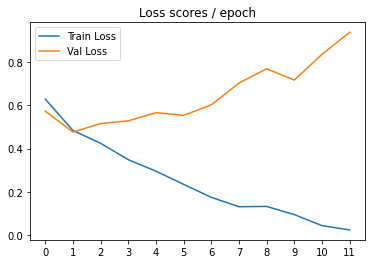

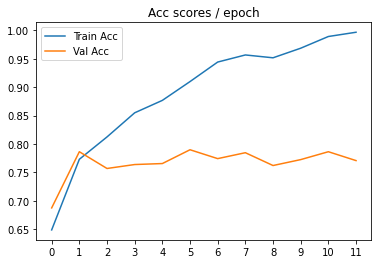

In [16]:
plot_loss_acc(trained_model1, 'loss','val_loss','Train Loss', 'Val Loss', 12, 'Loss scores / epoch')
plot_loss_acc(trained_model1, 'accuracy','val_accuracy','Train Acc', 'Val Acc', 12, 'Acc scores / epoch')

With early stopping we found the bes performance from epoch 2 with about 79% accuracy on validation and 0.47 validation loss. We can see in the charts that the accuracy for validation in orange stagnates around epoch 2 and the val_loss starts to increase again.

## Part 2: Data augmentation

Now we apply data augmentation to expose our model to more variation during training.

Change settings of images to achieve augmentation with a new ImageDataGenerator

In [18]:
## Mess with the picture settings
aug_train_data_gen = ImageDataGenerator(
        rescale=1./255,
        #rotation_range=35,
        shear_range= 0.85,
        #zoom_range=0.15,
        #horizontal_flip=True,
        #height_shift_range=0.05,
        #width_shift_range=0.05
        #featurewise_center=False,  
        #samplewise_center=False, 
        #featurewise_std_normalization=False,
        #samplewise_std_normalization=False,  
        #zca_whitening=False,
        #rotation_range=50,
        #width_shift_range=0.01, 
        #height_shift_range=0.01, 
        horizontal_flip=True, 
        #vertical_flip=False 
        )

Fetch images with new generator with other parameters than original

In [19]:
aug_X_train, aug_Y_train = image_generator(aug_train_data_gen, train_directory, 1600, True).next()

Found 1600 images belonging to 2 classes.


Example of a manipulated picture

Train Data Shape:  (1600, 64, 64, 3)

Label:  0.0 
Corresponding image: 


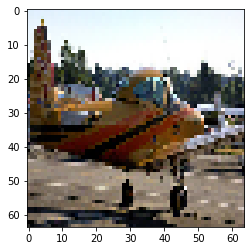

In [21]:
print("Train Data Shape: ",aug_X_train.shape)
print("\nLabel: ",aug_Y_train[29], "\nCorresponding image: ")
plt.imshow(aug_X_train[29]);

Train with augmented training data and validate model with early stopping if necessary

In [22]:
# create and compile model
mm2 = make_convnet(img_size, channel_rgb)

# train
trained_model2 = mm2.fit(
    aug_X_train,aug_Y_train,
    validation_data=(X_val,Y_val),
    epochs=epo,
    callbacks=[early_stopping] )

# get score and pring
mm2_score = mm2.evaluate(X_val, Y_val, verbose=0)
print('\nVal loss:', mm2_score[0])
print('Val accuracy:', mm2_score[1])

Epoch 1/100
50/50 [==============================] - 9s 182ms/step - loss: 0.6824 - accuracy: 0.6087 - val_loss: 0.6585 - val_accuracy: 0.6441
Epoch 2/100
50/50 [==============================] - 9s 178ms/step - loss: 0.5522 - accuracy: 0.7237 - val_loss: 0.5380 - val_accuracy: 0.7500
Epoch 3/100
50/50 [==============================] - 9s 176ms/step - loss: 0.5001 - accuracy: 0.7606 - val_loss: 0.5132 - val_accuracy: 0.7569
Epoch 4/100
50/50 [==============================] - 9s 183ms/step - loss: 0.4183 - accuracy: 0.8087 - val_loss: 0.4909 - val_accuracy: 0.7708
Epoch 5/100
50/50 [==============================] - 9s 180ms/step - loss: 0.3722 - accuracy: 0.8394 - val_loss: 0.5860 - val_accuracy: 0.7309
Epoch 6/100
50/50 [==============================] - 9s 179ms/step - loss: 0.3642 - accuracy: 0.8450 - val_loss: 0.4818 - val_accuracy: 0.7795
Epoch 7/100
50/50 [==============================] - 9s 179ms/step - loss: 0.3125 - accuracy: 0.8675 - val_loss: 0.5003 - val_accuracy: 0.7865

Print model summary

In [23]:
mm2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_2 (Dense)             (None, 100)              

Plot the loss and accuracy for training and validation data with the plot function

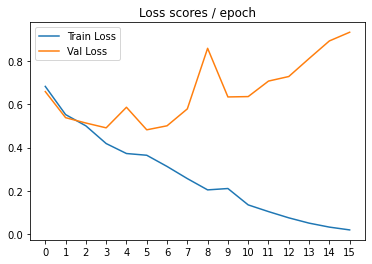

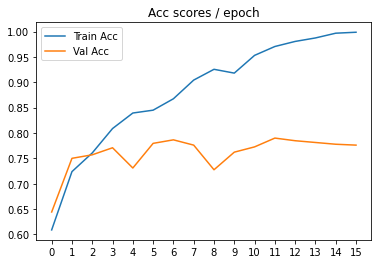

In [24]:
plot_loss_acc(trained_model2, 'loss','val_loss','Train Loss', 'Val Loss', 16, 'Loss scores / epoch')
plot_loss_acc(trained_model2, 'accuracy','val_accuracy','Train Acc', 'Val Acc', 16, 'Acc scores / epoch')

We use early stopping and we can see that best epoch was number 6 with the validation accuracy of about 78% and min loss of 0.48 when training with the augmented training data. This very similar to, but yet slightly lower tah, the initial model having about 79% accuracy and 0.47 loss. We tried some different parameters to tune the image generator to augment the data but did not hit a successful combination and with more time we could probably test our way to a slightly improved performance. 

From the charts above we can see the loss score and accuracy score of the validation data slightly more fluctuating than initial model but val accuracy seems to more or less stagnate while val loss increases after 6th epoch.

### Interlude: Applying a pre-trained convolutional neural network

Create VGG16 model and print summary

In [25]:
vggmodel = applications.VGG16(weights='imagenet', include_top=True)

553476096/553467096 [==============================] - 2s 0us/step


In [26]:
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Below is a function with the steps carried out below:
1. Choose an image from original training data 
2. load it as size 224,224 and show
3. Convert into numpy array (3-dimensions)
4. preprocess as required by VGG-16 and
5. reshape into (4-dimensions)

In [27]:
def single_img_predict(path, model):

    img_path = path # chosen image
    img = load_img(img_path, target_size=(224,224)) # load with required size
    img_array = img_to_array(img) # convert to array
    img_processed = preprocess_input(img_array) # preprocess
    img_final = img_processed.reshape(1, 224, 224, 3) # resape to 4 dimensions
    print("Image shape: ",img_final.shape) # confirm dimensions
    plt.imshow(img) # show image
    img_pred_label = model.predict(img_final) # predict class probabilities
    readable_pred = decode_predictions(img_pred_label) # decode to readable format
    print("Result of prediction:\n") # print result of prediction
    
    return readable_pred

Test image 1 from training data and print result:

Image shape:  (1, 224, 224, 3)
49152/35363 [=========================================] - 0s 0us/step
Result of prediction:



[[('n03785016', 'moped', 0.9190168),
  ('n03791053', 'motor_scooter', 0.067292474),
  ('n03208938', 'disk_brake', 0.013152348),
  ('n03127747', 'crash_helmet', 0.0002478767),
  ('n03792782', 'mountain_bike', 8.486677e-05)]]

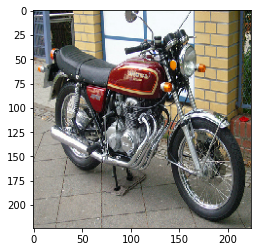

In [28]:
img1_path = 'a5_images/train/other/0000.jpg'
img1_pred = single_img_predict(img1_path, vggmodel)
img1_pred

The VGG-16 model correctly predicts the picture as a moped with high probability (0.91) and all suggestions are two wheeled vehicles, though perhaps the word motorcycle could have been a good description too not on the list.

Test image 2 from training data:

Image shape:  (1, 224, 224, 3)
Result of prediction:



[[('n03977966', 'police_van', 0.83321285),
  ('n03769881', 'minibus', 0.058642156),
  ('n03770679', 'minivan', 0.02127083),
  ('n02701002', 'ambulance', 0.020112561),
  ('n03417042', 'garbage_truck', 0.017216051)]]

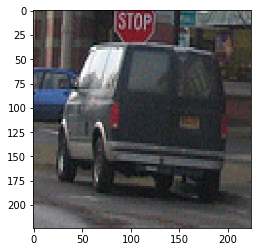

In [29]:
img2_path = 'a5_images/train/car/0060.jpg'
img2_pred = single_img_predict(img2_path, vggmodel)
img2_pred

The prediction is correct to idenfity a vehicle of the car type and further categorises the vehicle as a police van having the highest probability. This is interesting since to us it could just be a normal minibus.

## Part 3: Using VGG-16 as a feature extractor

Load VGG-16 model with different parameters than last time

In [30]:
feature_extractor = VGG16(
                        include_top=False, # to not use highest layers
                        weights='imagenet', 
                        input_shape=(img_size, img_size, 3) # override 224x224
                        )

58900480/58889256 [==============================] - 0s 0us/step


New ImageDataGenerator using preprocessing required for VGG-16 on the images

In [31]:
vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

Function with generator reading image directory, the new vgg_data_gen, applies VGG-16 model to generate and return 4-dimensional np array that it saves.

In [32]:
def create_vgg16_features(imgdir, img_size, batch_s, feature_extractor, vgg_data_gen, save_file, DataDir): 

        #imgdir = 'a5_images'
        #img_size = 64
        #batch_size = 1600

        train_generator = vgg_data_gen.flow_from_directory(
                imgdir + DataDir,
                target_size=(img_size, img_size),
                batch_size=batch_s,
                class_mode='binary',
                classes=['other', 'car'],
                seed=12345,
                shuffle=False)

        CNN_Features = feature_extractor.predict(train_generator)

        with open(save_file, 'wb') as f:
                np.save(f, CNN_Features)

Run function two times to predict features for both train and validation and making sure to save in different names.

In [ ]:
# Run function to predict features for train
train_directory = '/train'
save_file_train = 'cnn_features_train'
create_vgg16_features(imgdir, img_size, 1600, feature_extractor, vgg_data_gen, save_file_train, train_directory)

Found 1600 images belonging to 2 classes.


In [ ]:
# Run function to predict features for validation
val_directory = '/validation'
save_file_val = 'cnn_features_val'
create_vgg16_features(imgdir, img_size, 576, feature_extractor, vgg_data_gen, save_file_val, val_directory)

Found 576 images belonging to 2 classes.


train_on_cnnfeatures Function reads the two files created above, trains the classifier on training images and evaluate on the validation set. This function uses the help function get_labels to create the output labels.

In [34]:
def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))


def train_on_cnnfeatures(epo, early_stopper, channel):

    # Read file after that it has been saved --> both for train and val data
    with open('cnn_features_train', 'rb') as f:
        train_data = np.load(f)

    # Store labels for train data
    train_labels = get_labels(np.shape(train_data)[0])

    # Read file after that it has been saved --> both for train and val data
    with open('cnn_features_val', 'rb') as f:
        val_data = np.load(f)

    # Store labels for validation data
    val_labels = get_labels(np.shape(val_data)[0])

    
    # Initalize network
    model = Sequential()
    # First layer need to be flattened
    model.add(Flatten())
    # add layers
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Binary crossentropy loss function and Adam optimizer 
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

    # Fit model
    batch_size = 32
    model.fit(train_data, train_labels,
         validation_data=(val_data, val_labels), 
         epochs=epo, 
         callbacks=[early_stopper] )

    # Evalutate model
    score = model.evaluate(val_data, val_labels, verbose = 0)

    print('\nVal loss: ' + str(score[0]))
    print('Val Acc: ' + str(score[1]))

    return model 

Get results

In [35]:
final_model = train_on_cnnfeatures(epo, early_stopping, channel_rgb)

Epoch 1/100
50/50 [==============================] - 1s 5ms/step - loss: 2.0485 - accuracy: 0.8531 - val_loss: 1.2524 - val_accuracy: 0.8715
Epoch 2/100
50/50 [==============================] - 0s 4ms/step - loss: 0.2736 - accuracy: 0.9488 - val_loss: 0.9141 - val_accuracy: 0.8924
Epoch 3/100
50/50 [==============================] - 0s 3ms/step - loss: 0.0473 - accuracy: 0.9844 - val_loss: 0.8369 - val_accuracy: 0.8906
Epoch 4/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0049 - accuracy: 0.9994 - val_loss: 0.8153 - val_accuracy: 0.8872
Epoch 5/100
50/50 [==============================] - 0s 4ms/step - loss: 8.6985e-04 - accuracy: 1.0000 - val_loss: 0.8278 - val_accuracy: 0.8889
Epoch 6/100
50/50 [==============================] - 0s 4ms/step - loss: 4.8933e-04 - accuracy: 1.0000 - val_loss: 0.8327 - val_accuracy: 0.8906
Epoch 7/100
50/50 [==============================] - 0s 5ms/step - loss: 3.7178e-04 - accuracy: 1.0000 - val_loss: 0.8368 - val_accuracy: 0.8906
E

In [36]:
final_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (32, 2048)                0         
                                                                 
 dense_4 (Dense)             (32, 128)                 262272    
                                                                 
 dense_5 (Dense)             (32, 1)                   129       
                                                                 
Total params: 262,401
Trainable params: 262,401
Non-trainable params: 0
_________________________________________________________________


When we previously trained our model we had a validation accuracy of about 79% and this means the result from our new model having about 88% is much better. Now we're making use of the knowledge coming from the pre-trained VGG-16 model to enhance the performance of our model. We also use different layers in our model compared to the initial one.
 
We don't find it surprising that using feature extraction from the VGG-16 model help make the performance better. We guess that with some more data and additionally getting some imageg augmentation right we could come up at an even higher score. 


## 4. Visualizing the learned features

Get the weights in convolutional layer (4-dim np tensor: width x height x colors x no of convolutions)

In [37]:
 # Getting the first layer from the VGG16 model
first_layer_weights = vggmodel.get_weights()[0]

# Show shape of the data
first_layer_weights.shape

(3, 3, 3, 64)

Function to visualize patterns found by the convolutional layes

In [38]:
def kernel_image(weights, i, positive):
    '''
    Input:
        - weights: this is the feature-layer from the selected model
        - i: 
        - positive: this is a boolean flag, if its 'True' you will get 
                    the positive filters, if the value is 'False' the 
                    method will get teh negative values from th filter

    Return: positive OR negative features.

    Get the negative or positive part of the filter.
    '''
    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k

    # clip the values: if we're looking for positive values, 
    # just keep the positive part; vice versa for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m 

    return k

Running the kernel_image method for both negative and positive filter and stores it in a variable respectivly.

In [39]:
ki_pos = kernel_image(first_layer_weights, 1, True)
ki_neg = kernel_image(first_layer_weights, 1, False)

Peak at the positive and negative filter data

In [40]:
# look at the positive filter data
ki_pos

array([[[ 0.5797072 ,  0.10320117, -0.        ],
        [ 0.80110663,  0.23401682, -0.        ],
        [ 0.6707614 ,  0.20689425, -0.        ]],

       [[ 0.7333233 ,  0.15348299, -0.        ],
        [ 1.        ,  0.32531253, -0.        ],
        [ 0.79925686,  0.22865967, -0.        ]],

       [[ 0.6393736 ,  0.15659423, -0.        ],
        [ 0.8481153 ,  0.27044255, -0.        ],
        [ 0.68567234,  0.20919381, -0.        ]]], dtype=float32)

In [41]:
# look at the negative filter data
ki_neg

array([[[-0.        , -0.        ,  0.9205507 ],
        [-0.        , -0.        ,  0.90817535],
        [-0.        , -0.        ,  0.82276285]],

       [[-0.        , -0.        ,  1.        ],
        [-0.        , -0.        ,  0.946536  ],
        [-0.        , -0.        ,  0.92963   ]],

       [[-0.        , -0.        ,  0.88486856],
        [-0.        , -0.        ,  0.88840836],
        [-0.        , -0.        ,  0.8371405 ]]], dtype=float32)

Function to plot and visualize the patters found by the convolutional layer

In [42]:
def plot_layer(layer_data):
    '''
    input: a numpy array 

    This method takes an numpy array and plots it as an image.
    The image will represen the values with diffetent brightness 
    depending on the value, e.g. higher number gives darker color.
    '''
    pyplot.imshow(layer_data, interpolation='nearest')
    pyplot.show()

Iterate through some layers and plot the positive and negative filter

Convolutional layer: 0 Positive filter:


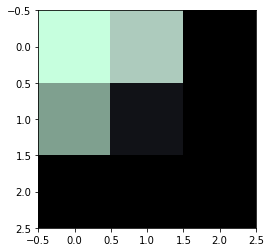

Convolutional layer: 0 Negative filter:


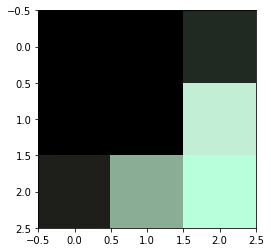

Convolutional layer: 5 Positive filter:


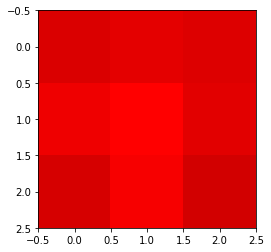

Convolutional layer: 5 Negative filter:


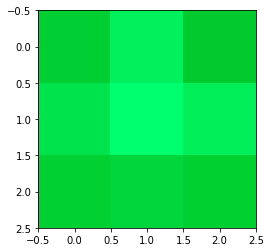

Convolutional layer: 10 Positive filter:


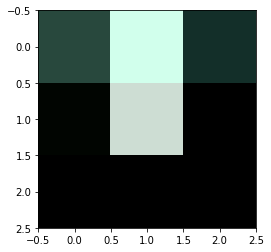

Convolutional layer: 10 Negative filter:


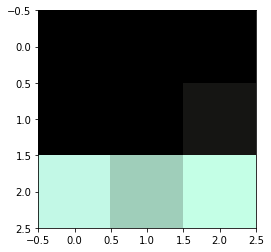

Convolutional layer: 15 Positive filter:


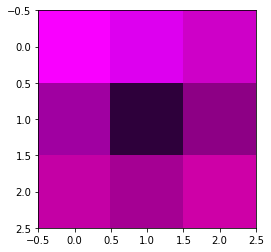

Convolutional layer: 15 Negative filter:


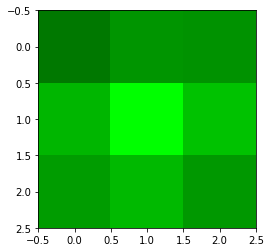

Convolutional layer: 20 Positive filter:


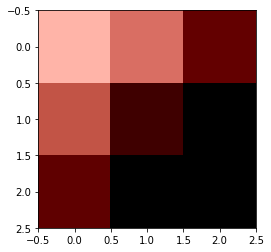

Convolutional layer: 20 Negative filter:


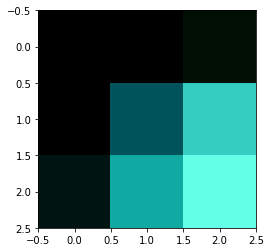

Convolutional layer: 25 Positive filter:


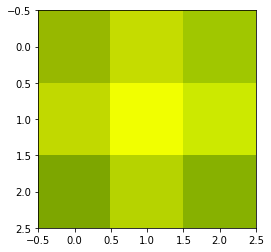

Convolutional layer: 25 Negative filter:


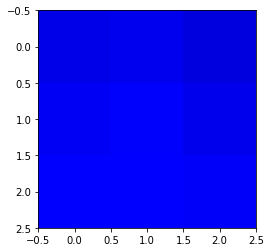

Convolutional layer: 30 Positive filter:


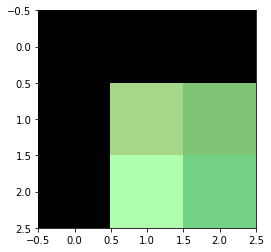

Convolutional layer: 30 Negative filter:


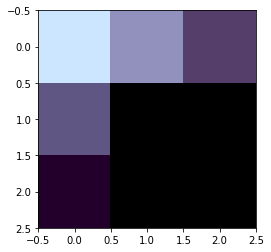

Convolutional layer: 35 Positive filter:


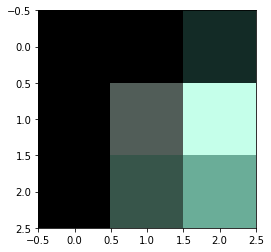

Convolutional layer: 35 Negative filter:


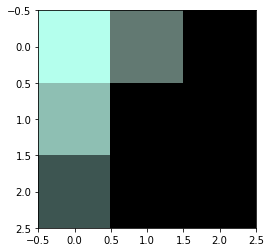

Convolutional layer: 40 Positive filter:


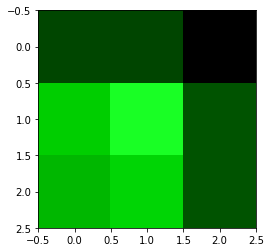

Convolutional layer: 40 Negative filter:


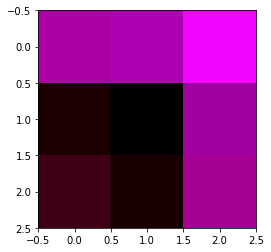

Convolutional layer: 45 Positive filter:


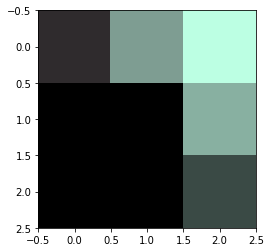

Convolutional layer: 45 Negative filter:


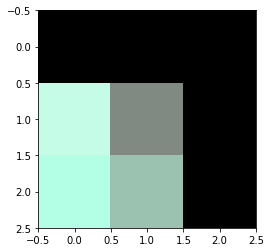

Convolutional layer: 50 Positive filter:


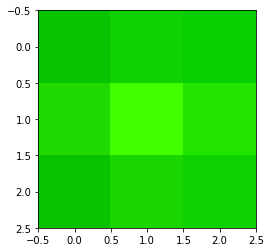

Convolutional layer: 50 Negative filter:


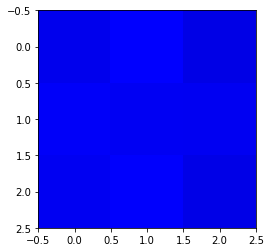

Convolutional layer: 55 Positive filter:


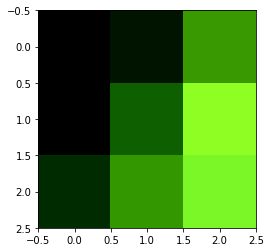

Convolutional layer: 55 Negative filter:


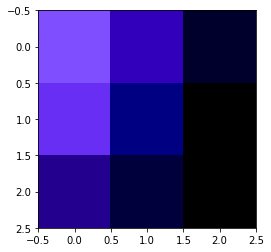

Convolutional layer: 60 Positive filter:


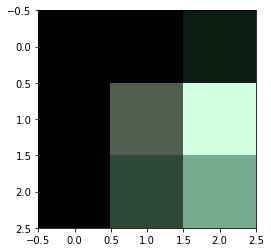

Convolutional layer: 60 Negative filter:


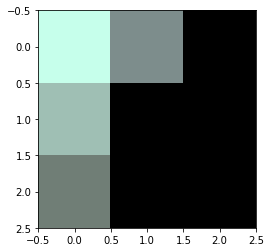

In [43]:
for i in range(0,63,5):
    ki_pos = kernel_image(first_layer_weights, i, True)
    ki_neg = kernel_image(first_layer_weights, i, False)
    print("Convolutional layer:",i,"Positive filter:")
    plot_layer(ki_pos)
    print("Convolutional layer:",i,"Negative filter:")
    plot_layer(ki_neg)